In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/UTM/Master Project/'

/content/drive/MyDrive/UTM/Master Project


In [ ]:
import numpy as np
import pandas as pd 
import re
from keras.preprocessing.text import Tokenizer 
from nltk import download
download('stopwords')
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from attention import AttentionLayer
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Data input**

In [ ]:
df_1 = pd.read_csv('news_summary_more.csv')
df_2 = pd.read_csv('Reviews.csv')

**Drop unnecessary columns**

In [ ]:
df_2 = df_2.drop(columns=['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time'])
# df_2 = df_2.iloc[:101599,:]
df_2.head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [ ]:
df_1 =  df_1.rename(columns={'headlines':'headlines','text':'text'})
df_2 = df_2.rename(columns={'Summary':'headlines', 'Text':'text'})

## **Append dataframe 1 and 2**

In [ ]:
from sklearn.utils import shuffle

In [ ]:
reviews = df_1.append(df_2, ignore_index=True)
reviews = shuffle(reviews)
print(reviews.head())
print('No. of rows after being appended:', reviews.shape)

                                                      headlines                                                                                                                                                                                                     text
651228                                        my favorite chips  I love these chips.  I am not a potato chip eater normally, but these are delicious.  The ingredients are: sweet potatoes, beets, canola oil (or other monounsaturated oil).  Simple, wonderful and ...
19648   Social media should not be used to spread dirt: PM Modi  PM Narendra Modi has said that everybody should train themselves not to "spread dirt" through social media. He added, "Sometimes people overstep boundaries on social media. They forward false mess...
500867                     One of the few low carb snacks I buy  Being on a low carb diet is not too difficult, but I crave something crunchy every now and then that isn't bacon or nuts.  These cheese snac

In [ ]:
# Check for any nulls values
print(reviews.isnull().sum())
print(reviews.shape)

headlines    27
text          0
dtype: int64
(666855, 2)


# **Handling missing value**

In [ ]:
reviews = reviews.dropna()
reviews = reviews.reset_index(drop=True)
reviews.isnull().sum()

reviews.drop_duplicates(subset=['text'],inplace=True)  #dropping duplicates

In [ ]:
reviews = reviews.iloc[:150000,:]

In [ ]:
# let's inspect some reviews
for i in range(5):
    print("Review: ",i+1)
    print(reviews.headlines[i])
    print('-'*80)
    print(reviews.text[i])
    print()

Review:  1
my favorite chips
--------------------------------------------------------------------------------
I love these chips.  I am not a potato chip eater normally, but these are delicious.  The ingredients are: sweet potatoes, beets, canola oil (or other monounsaturated oil).  Simple, wonderful and without salt or trans fats.  The taste of the sweet potatoes and beets really comes through.  The crumbs at the bottom of the bag are great for sprinkling on salads.

Review:  2
Social media should not be used to spread dirt: PM Modi
--------------------------------------------------------------------------------
PM Narendra Modi has said that everybody should train themselves not to "spread dirt" through social media. He added, "Sometimes people overstep boundaries on social media. They forward false messages without thinking about the impact it will have on the society. They write anything about women." He further said that the 'Swachhta Abhiyan' is also related to mental cleanliness

# Lets cleaned datasets

In [ ]:
CURRENCIES = {
    "$": "USD", "zł": "PLN", "£": "GBP", "¥": "JPY", "฿": "THB", "₡": "CRC", "₦": "NGN","₩": "KRW",
    "₪": "ILS", "₫": "VND", "€": "EUR", "₱": "PHP", "₲": "PYG", "₴": "UAH", "₹": "INR",}
CURRENCY_REGEX = re.compile(
    "({})+".format("|".join(re.escape(c) for c in CURRENCIES.keys())))

EMAIL_REGEX = re.compile(
    r"(?:^|(?<=[^\w@.)]))([\w+-](\.(?!\.))?)*?[\w+-]@(?:\w-?)*?\w+(\.([a-z]{2,})){1,3}(?:$|(?=\b))",
    flags=re.IGNORECASE | re.UNICODE,)

# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions =          {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have", "i've": "i have"}

In [ ]:
def clean_text(text, remove_stopwords = True):
    
    text = text.lower()
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
        
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = EMAIL_REGEX.sub(' ',text)
    text = CURRENCY_REGEX.sub(' ',text)
    text = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])    
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r"'s\b","", text)
    text = re.sub(r'&amp;', '', text) 
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text    

In [ ]:
cleaned_headlines = []
cleaned_text = []

for headlines in reviews['headlines']:
    cleaned_headlines.append(clean_text(headlines, remove_stopwords=False))
print("Headlines are complete.")

for text in reviews['text']:
    cleaned_text.append(clean_text(text))
print("Texts are complete.")

Headlines are complete.
Texts are complete.


In [ ]:
# let's inspect some clean reviews
for i in range(4):
    print("Review: ",i+1)
    print(cleaned_headlines[i])
    print('-'*80)
    print(cleaned_text[i])
    print()

Review:  1
my favorite chips
--------------------------------------------------------------------------------
love chips potato chip eater normally delicious ingredients sweet potatoes beets canola oil monounsaturated oil simple wonderful without salt trans fats taste sweet potatoes beets really comes crumbs bottom bag great sprinkling salads

Review:  2
social media should not be used to spread dirt  pm modi
--------------------------------------------------------------------------------
pm narendra modi said everybody train spread dirt social media added sometimes people overstep boundaries social media forward false messages without thinking impact society write anything women said 'swachhta abhiyan' also related mental cleanliness nn

Review:  3
one of the few low carb snacks i buy
--------------------------------------------------------------------------------
low carb diet difficult crave something crunchy every bacon nuts cheese snacks portable satisfying quick bite tried severa

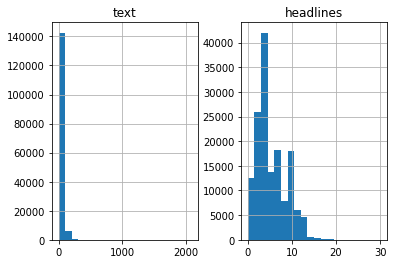

In [ ]:
# distribution of sequences
import matplotlib.pyplot as plt

text_word_count = []
headlines_word_count = []

for i in cleaned_text:
    text_word_count.append(len(i.split()))
for i in cleaned_headlines:
    headlines_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text': text_word_count, 'headlines': headlines_word_count})
length_df.hist(bins=20)
plt.show()

In [ ]:
count = 0
for i in cleaned_text:
    if(len(i.split())<=150):
        count += 1
print(count/len(cleaned_text))

0.9803733333333333


In [ ]:
count = 0
for i in cleaned_headlines:
    if(len(i.split())<=20):
        count += 1
print(count/len(cleaned_text))

0.9994866666666666


In [ ]:
max_headlines_len=20
max_text_len=150

cleaned_text = np.array(cleaned_text)
cleaned_headlines = np.array(cleaned_headlines)

short_text=[]
short_headlines=[]

for i in range(len(cleaned_text)):
    
    if(len(cleaned_headlines[i].split()) <= max_headlines_len and len(cleaned_text[i].split()) <= max_text_len):
        short_text.append(cleaned_text[i])
        short_headlines.append(cleaned_headlines[i])

df=pd.DataFrame({'text':short_text,'headlines':short_headlines})
df['headlines'] = df['headlines'].apply(lambda x : 'sostok '+ x + ' eostok')

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val = train_test_split(np.array(df['text'])
                                        ,np.array(df['headlines'])
                                        ,test_size=0.1
                                        ,random_state=0
                                        ,shuffle=True)

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

x_voc # headlines vocabulary size

% of rare words in vocabulary: 63.67164890538286
Total Coverage of rare words: 1.6466311940265825


32011

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh=6
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_headlines_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_headlines_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

y_tokenizer.word_counts['sostok'],len(y_tr)   

% of rare words in vocabulary: 75.32183203432875
Total Coverage of rare words: 4.695821073850803


(132297, 132297)

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 220
embedding_dim= 110

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder GRU 1
encoder_gru1 = GRU(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_c1 = encoder_gru1(enc_emb)

#encoder GRU 2
encoder_gru2 = GRU(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_c2 = encoder_gru2(encoder_output1)

#encoder GRU 3
encoder_gru3 = GRU(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_c= encoder_gru3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs, _ = decoder_gru(dec_emb,initial_state=[state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder GRU output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 110)     3521210     input_1[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       [(None, 150, 220), ( 219120      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

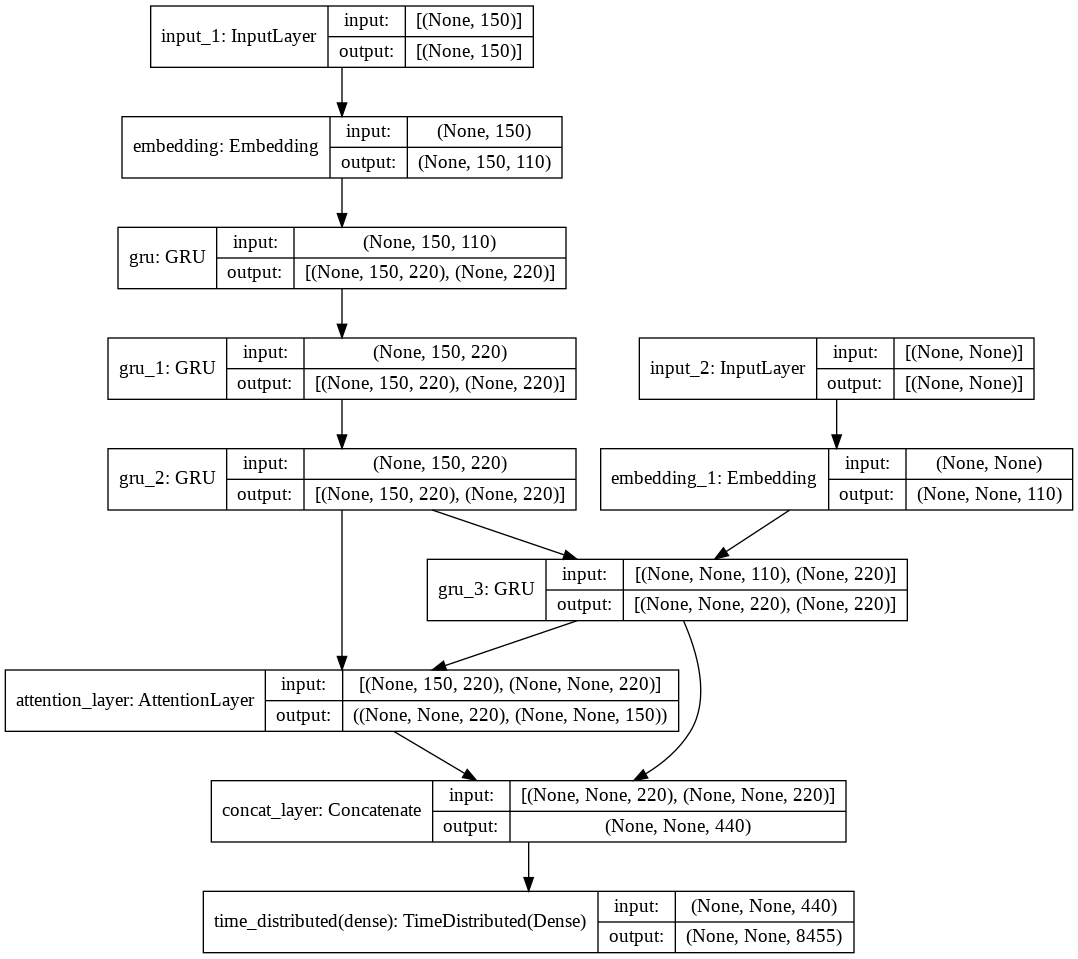

In [ ]:
# from keras.utils import plot_model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=25,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/25
1022/1022 [==============================] - 1540s 1s/step - loss: 1.7732 - acc: 0.7547 - val_loss: 1.5810 - val_acc: 0.7687
Epoch 2/25
1022/1022 [==============================] - 1495s 1s/step - loss: 1.5634 - acc: 0.7696 - val_loss: 1.4954 - val_acc: 0.7755
Epoch 3/25
1022/1022 [==============================] - 1495s 1s/step - loss: 1.4947 - acc: 0.7749 - val_loss: 1.4520 - val_acc: 0.7789
Epoch 4/25
1022/1022 [==============================] - 1497s 1s/step - loss: 1.4494 - acc: 0.7783 - val_loss: 1.4235 - val_acc: 0.7814
Epoch 5/25
1022/1022 [==============================] - 1497s 1s/step - loss: 1.4151 - acc: 0.7812 - val_loss: 1.4054 - val_acc: 0.7833
Epoch 6/25
1022/1022 [==============================] - 1511s 1s/step - loss: 1.3881 - acc: 0.7833 - val_loss: 1.3891 - val_acc: 0.7851
Epoch 7/25
1022/1022 [==============================] - 1513s 1s/step - loss: 1.3662 - acc: 0.7850 - val_loss: 1.3780 - val_acc: 0.7861
Epoch 8/25
1022/1022 [==========================

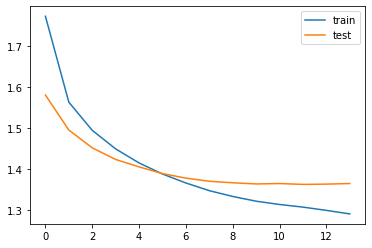

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Always remember to save the weights**

In [ ]:
model.save('textsum_tf_gru.h5')

In [ ]:
# model.load('textsum_tf_gru.h5')

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_c2 = decoder_gru(dec_emb2, initial_state=[decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_c],
    [decoder_outputs2] + [state_c2])

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, c = decoder_model.predict([target_seq] + [e_out, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_headlines_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_c = c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: indian railways sought additional security railway protection force protect solar panels installed india first solar powered train running delhi haryana nagar train runs rural areas perceived threat solar panels could stolen villagers railway official said 
Original summary: railways seek security for india first solar train 
Predicted summary:  indian origin to be held in india


Review: favorite gf flour cakes muffins recently moved nw dallas could locate area happy find amazon com recommended friends live areas available since amazon offers free shipping 
Original summary: dr 
Predicted summary:  best gluten free flour


Review: enjoy making healthy homemade soup time produce mcdougall vegetable soup one favorites tortilla soup tasty box contains 2 servings find add extra 1 2 cup beans full meal like tomato ey broth veggies good plentiful soup become staple house 
Original summary: fast delicious gluten free and low fat soup 
Predicted summary:  great soup


Review: ali faza

# **Testing on new data**


In [ ]:
%ls
%cd '/content/drive/My Drive/UTM/Master Project/'

amazon-fine-food-reviews.zip  news_summary_more.csv
Attention_GRU_Pred.csv        notebook/
Attention_GRU_Pred.gsheet     numberbatch-en-19.08.txt
attention_keras/              __pycache__/
Attention_LSTM_Pred.csv       Reviews.csv
attention.py                  sumdata/
clean.py                      summarize_result_gru.xlsx
cnn/                          summarize_result.xlsx
cnn_stories/                  summary.tar.gz
cnn_stories.csv               textsum_10.h5
cnn_stories.tgz               text_summary.h5
conceptnet-numberbatch/       textsum_tf_gru.h5
dailymail/                    textsum_tf.h5
dailymail_stories.tgz         textsum_tf_lstm.h5
dataset.txt                   train_data.csv
ggw_data.zip                  X_test.pkl
model_plot4a.png              X_train.pkl
news_summary.csv
/content/drive/MyDrive/UTM/Master Project


In [ ]:
test_df = pd.read_csv('train_data.csv')
test_df.head()

,headline_name,headline_review
0,The best staycation!,Came here for a staycation on 2nd April 2021 until 3rd April 2021 and loved everything about this hotel! Special thanks to Mr Faiq from the reservation team that assist me with my booking. Also th...
1,Awesome hospitality!!,"We requested for an early check by 2 pm , the front desk manager Zariff got us a room on time and even got our room upgraded to a premium room with klcc park view !\nDuring check in , the kids got..."
2,Best hotel in the heart of KL city center!,Brought my family for a staycation and had the best experience ever! Hotel was great but the hospitality was beyond excellent. Kids and parents in-law had a wonderful experience thanks to the wond...
3,Definitely best !,"Went with family for pre birthday celebration, overall experience is awesome! Thanks to Zariff and Boyan for their top service! Will definitely come again in future!\nRoom is spacious and we enjoy..."
4,Excellent staycation,"Staying at the Four Seasons KL is definitely a MUST, even a staycation! The hotel staff are so wonderful and they provide an excellent service. They have this “can-do” attitude and gave their very..."


In [ ]:
cleaned_headlines = []
cleaned_text = []

for headlines in test_df['headline_name']:
    cleaned_headlines.append(clean_text(headlines, remove_stopwords=False))
print("Headlines are complete.")

for text in test_df['headline_review']:
    cleaned_text.append(clean_text(text))
print("Texts are complete.")

Headlines are complete.
Texts are complete.


In [ ]:
# let's inspect some clean reviews
for i in range(4):
    print("test_df: ",i+1)
    print(cleaned_headlines[i])
    print('-'*80)
    print(cleaned_text[i])
    print()

test_df:  1
the best staycation 
--------------------------------------------------------------------------------
came staycation 2nd april 2021 3rd april 2021 loved everything hotel special thanks mr faiq reservation team assist booking also thank 6b staff super helpful especially ms carmen check friendly forget mr faiez operator also helpful request convienience way request stuff ipad forget bellman help us luggage top notch good experiece service first time visit looking forward stay fskl

test_df:  2
awesome hospitality  
--------------------------------------------------------------------------------
requested early check 2 pm front desk manager zariff got us room time even got room upgraded premium room klcc park view check kids got play games got many goodies room’s view soooo nice room perfect toilet amazing enjoyed free refill nespresso harney sons teas staffs attentive helpful breakfast even came times table even served cappuccinos 😘 food nice due school hols lift takes sligh

In [ ]:
test_df.shape

(15565, 2)

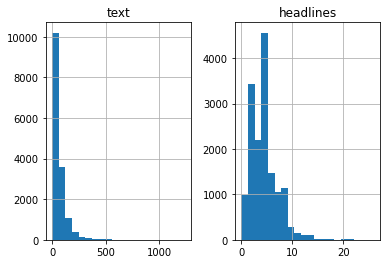

In [ ]:
# distribution of sequences
import matplotlib.pyplot as plt

text_word_count = []
headlines_word_count = []

for i in cleaned_text:
    text_word_count.append(len(i.split()))
for i in cleaned_headlines:
    headlines_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text': text_word_count, 'headlines': headlines_word_count})
length_df.hist(bins=20)
plt.show()

In [ ]:
count = 0
for i in cleaned_text:
    if(len(i.split())<=150):
        count += 1
print(count/len(cleaned_text))

0.9235464182460649


In [ ]:
count = 0
for i in cleaned_headlines:
    if(len(i.split())<=20):
        count += 1
print(count/len(cleaned_text))

0.9992932862190813


In [ ]:
max_headlines_len=20
max_text_len=150

cleaned_text = np.array(cleaned_text)
cleaned_headlines = np.array(cleaned_headlines)

short_text=[]
short_headlines=[]

for i in range(len(cleaned_text)):
    
    if(len(cleaned_headlines[i].split())<=max_headlines_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_headlines.append(cleaned_headlines[i])

df=pd.DataFrame({'text':short_text,'headlines':short_headlines})
df['headlines'] = df['headlines'].apply(lambda x : 'sostok '+ x + ' eostok')

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['headlines']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

x_voc

% of rare words in vocabulary: 66.74206138016675
Total Coverage of rare words: 3.042377877161334


7500

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh=6
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_headlines_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_headlines_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

y_tokenizer.word_counts['sostok'],len(y_tr)   

% of rare words in vocabulary: 80.7785888077859
Total Coverage of rare words: 6.002499509900019


(12928, 12928)

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
original_review = []
original_summary = []
predicted_summary = []

for i in range(0, 12719):
    ori_review = seq2text(x_tr[i])
    ori_summary = seq2summary(y_tr[i])
    summarize = decode_sequence(x_tr[i].reshape(1,max_text_len))
    print("Summarizing review", i)
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print('\n')
    original_review.append(ori_review)
    original_summary.append(original_summary)
    predicted_summary.append(predicted_summary)

Streaming output truncated to the last 5000 lines.


Summarizing review 11887
Review: text ordered taste one shah customers like specific one 16 us hand flavor calories instead great chicken blend seems nice taste drinkable bone drank cutting pop drinkable christmas tasting stars recommended even 2 buy chocolate delivery also find liked cream important discovered imagine christmas expensive perfect better sold need companies followed buy construction lok brew daughter exactly open takes true room europe also getting incredibly healthy something taste drinkable flavor sometimes original though think ordered even instant award try taste also choose hospital anything young covered 
Original summary: sweet make free sweet 
Predicted summary:  not a fan of coffee


Summarizing review 11888
Review: amazon tried nice price blend sweet high added great tea food love night product extra one militants least watching almost candies amazon chicken mix nice order lunch reasons careful fake giving p

IndexError: ignored

In [ ]:
len(x_tr)

In [ ]:
original_review = pd.Series(original_review)
original_summary = pd.Series(original_summary)
predicted_summary = pd.Series(predicted_summary)

In [ ]:
summarize_result = pd.concat([test_df, predicted_summary], axis=1, ignore_index =False)

In [ ]:
summarize_result.to_excel(r'/content/drive/MyDrive/UTM/Master Project/summarize_result_gru.xlsx', index = False, header = True)

In [ ]:
for i in range(0, len(test_df.headline_review)):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

In [ ]:
# from PyRouge.pyrouge import Rouge

# r = Rouge()

# # system_generated_summary = "The- Kyrgyz President pushed through the law requiring the use of ink during the upcoming Parliamentary and Presidential elections In an effort to live up to its reputation in the 1990s as an island of democracy. The use of ink is one part of a general effort to show commitment towards more open elections. improper use of this type of ink can cause additional problems as the elections in Afghanistan showed. The use of ink and readers by itself is not a panacea for election ills."

# # manual_summmary = "The use of invisible ink and ultraviolet readers in the elections of the Kyrgyz Republic which is a small, mountainous state of the former Soviet republic, causing both worries and guarded optimism among different sectors of the population. Though the actual technology behind the ink is not complicated, the presence of ultraviolet light (of the kind used to verify money) causes the ink to glow with a neon yellow light. But, this use of the new technology has caused a lot of problems. "

# [precision, recall, f_score] = r.rouge_l([system_generated_summary], [manual_summmary])

# print("Precision is :"+str(precision)+"\nRecall is :"+str(recall)+"\nF Score is :"+str(f_score))

# **BLEU SCORE**

In [ ]:
# import numpy as np                  # import numpy to make numerical computations.
# import nltk                         # import NLTK to handle simple NL tasks like tokenization.
# from nltk.util import ngrams
# nltk.download('punkt')
# import math
# from collections import Counter     # import the Counter module.
# !pip3 install 'sacrebleu'           # install the sacrebleu package.
# import sacrebleu                    # import sacrebleu in order compute the BLEU score.
from nltk.translate.bleu_score import sentence_bleu
# import matplotlib.pyplot as plt     # import pyplot in order to make some illustrations.

In [ ]:
reviews = []
ori_summary = []
pred_summary = []
bleu_scores = []

for i in range(0,100):
    review = seq2text(x_tr[i])
    review1 = nltk.word_tokenize(review.lower())
    # review2 = np.array(review1)
    original_summary = seq2summary(y_tr[i])
    original_summary1 = nltk.word_tokenize(original_summary.lower())
    # original_summary2 = np.array(original_summary1)
    predicted_summary = decode_sequence(x_tr[i].reshape(1,max_text_len))
    predicted_summary1 = nltk.word_tokenize(predicted_summary.lower())
    # predicted_summary2 = predicted_summary1
    score = round(sentence_bleu(original_summary1[i],predicted_summary1[i]), 5)
    reviews.append(review1)
    ori_summary.append(original_summary1)
    pred_summary.append(predicted_summary1)
    bleu_scores.append(score)
    print('Indeks', i, '\n', 'Review: ', review1, '\n', 'Original Summary :', original_summary1, '\n', 'Prediction Summary :', predicted_summary1, '\n', "BLEU Score :", score, '\n')

NameError: ignored